In [32]:
import sys
sys.path.append('../')

from typing import Tuple, Union, List
import pandas as pd
import numpy as np
import networkx as nx
from tqdm.notebook import tqdm as tqdm

# import node2vec

import torch
import torch.nn as nn

import torch_geometric as pyg
from torch_geometric.utils.convert import from_networkx

from src.utils import *
from dataset import *
from src.train import train, test
from src.model import KnnEstimator

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from IPython.display import clear_output

%matplotlib inline
%load_ext autoreload
%autoreload 2

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
G = nx.readwrite.read_gpickle('data/network128.gpickle')

In [34]:
# Pytorch geometric Data object. For now used only for storing node embedding. 
# Supposed to be used in the future for obtaining node embeddings.
pyg_graph = from_networkx(G)
pyg_graph.to(device)

Data(x=[60789, 128], edge_index=[2, 151294], lng=[60789], lat=[60789], id=[60789], dist=[151294])

$$T(a) = \sum_{b \neq a,\space b\subset Train } T(b)w(a, b), \textrm{where summation is calculated for the {\bf k} nearest neighbors.}$$

$$ w(a,b)= k \frac{u(a,b)}{\sum_{b \neq a} u(a, b)}  + (1-k) \frac{g(a,b)}{\sum_{b \neq a} g(a,b)};$$

$u(a, b) = exp(-\lambda_1 d(a, b));$

$g(a, b) = exp(-\lambda_2 similarity(x_a, x_b))$, where similarity is cosine distance (can be dot product by the way);

$x_a$ is an embedding for a node **a**;

So for this model $k$, $\lambda_1$, $\lambda_2$ are optimized.

In [45]:
def weight_fn(dists, lamb):
    return torch.exp(-lamb * dists)


class Estimator(KnnEstimator):
    def __init__(self, pyg_graph: pyg.data.Data, observations: Tuple[List, List]) -> None:
        super().__init__(pyg_graph, observations)

        self.k = nn.Parameter(torch.rand(1))
        # self.k = torch.tensor([1.0]).to(device)
        self.lambda_1 = nn.Parameter(torch.rand(1))
        self.lambda_2 = nn.Parameter(torch.rand(1))

    def forward(self, X):
        # getting nearest observed nodes
        X_indices = torch.as_tensor(self.node_to_gidx(X.detach().cpu()))
        dists, indices = self.get_kneighbors(X_indices)
        dists = dists.to(device)
        indices = indices.to(device)

        # finding corresponding node embedding of neighbors
        neighbors_indices = torch.as_tensor(self.node_to_gidx(self.obs_nodes[indices]), device=device)
        neighbors_embeds = self.g.x[neighbors_indices]
        
        # computing similarities between node ans its neighbors
        X_embeds = self.g.x[X_indices]
        similarities = nn.functional.cosine_similarity(X_embeds[:, None], neighbors_embeds, dim=2)

        dist_weights = weight_fn(dists, self.lambda_1)
        simi_weights = weight_fn(similarities, self.lambda_2)

        # sum normalizization
        dist_weights = nn.functional.normalize(dist_weights, p=1)
        simi_weights = nn.functional.normalize(simi_weights, p=1)

        att_weights = self.k * dist_weights + (1 - self.k) * simi_weights
        targets = self.obs_targets[indices].to(device)

        # interpolation 
        result = torch.sum(att_weights.mul(targets), dim=-1)

        return result

In [46]:
results = dict()

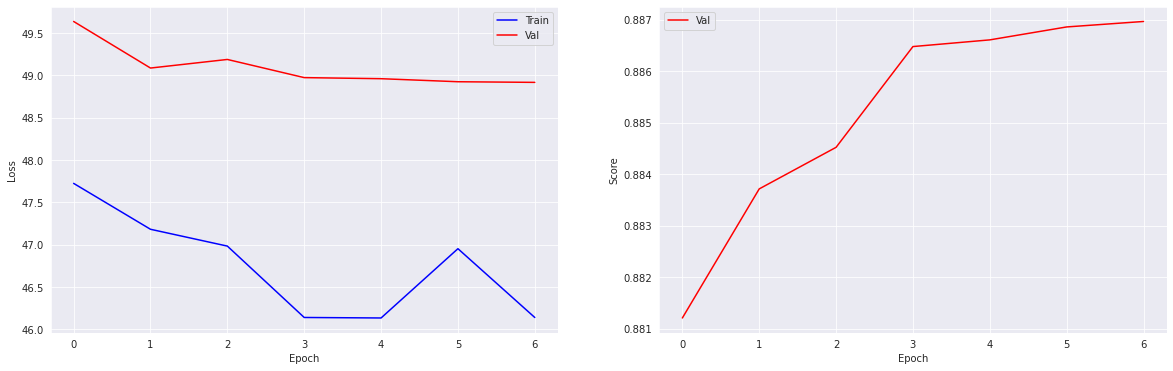

Day 1, Test loss: 54.3455, test score: 0.8920


In [51]:
loss_fn = nn.HuberLoss(delta=20).to(device)

for day in range(1, 2):
    path = f'datasets/day_{day}.dat'

    try:
        ds = torch.load(path)
    except:
        continue

    train_loader, val_loader, test_loader = make_data_loaders_from_dataset(ds, train_batch_size=128)
    train_batches = [batch for batch in train_loader]
    train_nodes = torch.cat([batch[0] for batch in train_batches])
    train_targets = torch.cat([batch[1] for batch in train_batches])

    model = Estimator(pyg_graph, (train_nodes, train_targets)).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=3e-3)
    # scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 2, gamma=0.1)

    best_model = train(model, train_loader, val_loader, loss_fn, optimizer, device, num_epochs=6, plotting=True)
    test_loss, test_score = test(best_model, test_loader, loss_fn, device)
    
    # for name, param in best_model.named_parameters():
        # print(name, param)

    results[f'day_{day}'] = test_score 
    print(f'Day {day}, Test loss: {test_loss:.4f}, test score: {test_score:.4f}')

In [7]:
import json

with open('results/gnn0.json', mode='w') as f:
    json.dump(results, f, indent=4)